# Natural Language Inference with SNLI Dataset

Implementation of NLI data loading using Stanford Natural Language Inference (SNLI) corpus.

## Setup and Imports

In [1]:
import os
import re
import torch
from torch.utils.data import Dataset, DataLoader
import collections
import hashlib
import requests
import zipfile
import matplotlib.pyplot as plt
import numpy as np

## Utility Functions
- Download and extract dataset
- Tokenization and padding
- Text preprocessing

In [2]:
DATA_HUB = {}

def download(name, cache_dir=os.path.join('..', 'data')):
    """Download file from DATA_HUB"""
    assert name in DATA_HUB
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """Download and extract zip file"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        import tarfile
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files supported'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def tokenize(lines, token='word'):
    """Split text into word tokens"""
    return [line.split() for line in lines] if token == 'word' else [list(line) for line in lines]

def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences to fixed length"""
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

## Vocabulary Class
Build vocabulary from tokens with frequency threshold

In [3]:
class Vocab:
    """Vocabulary for text"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Count and sort by frequency
        counter = self._count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # Build vocabulary
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def _count_corpus(self, tokens):
        """Count token frequencies"""
        if len(tokens) == 0 or isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens)

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        return 0

## Load SNLI Dataset
Download and parse SNLI corpus (premise, hypothesis, label)

In [4]:
# Register SNLI dataset
DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = download_extract('SNLI')

In [5]:
def read_snli(data_dir, is_train):
    """Parse SNLI dataset into premises, hypotheses, and labels"""
    def extract_text(s):
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()

    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt' if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

# Load train and test data
train_data = read_snli(data_dir, is_train=True)
test_data = read_snli(data_dir, is_train=False)

## Inspect Examples
View sample premise-hypothesis pairs with labels

In [6]:
label_names = {0: 'entailment', 1: 'contradiction', 2: 'neutral'}

print("Sample training examples:\n")
for i, (premise, hypothesis, label) in enumerate(zip(train_data[0][:3], train_data[1][:3], train_data[2][:3])):
    print(f"Example {i+1}:")
    print(f"  Premise: {premise}")
    print(f"  Hypothesis: {hypothesis}")
    print(f"  Label: {label_names[label]}\n")

Sample training examples:

Example 1:
  Premise: A person on a horse jumps over a broken down airplane .
  Hypothesis: A person is training his horse for a competition .
  Label: neutral

Example 2:
  Premise: A person on a horse jumps over a broken down airplane .
  Hypothesis: A person is at a diner , ordering an omelette .
  Label: contradiction

Example 3:
  Premise: A person on a horse jumps over a broken down airplane .
  Hypothesis: A person is outdoors , on a horse .
  Label: entailment



## SNLI Dataset Class
Custom PyTorch Dataset with tokenization and padding

In [7]:
class SNLIDataset(Dataset):
    """Custom dataset for SNLI"""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = tokenize(dataset[0])
        all_hypothesis_tokens = tokenize(dataset[1])
        # Build or reuse vocabulary
        if vocab is None:
            self.vocab = Vocab(all_premise_tokens + all_hypothesis_tokens,
                              min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        # Convert to indices and pad
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])

    def _pad(self, lines):
        return torch.tensor([truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>']) for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

## Create DataLoaders
Initialize train/test iterators with batching

In [8]:
def load_data_snli(batch_size, num_steps=50):
    """Return SNLI data iterators and vocabulary"""
    data_dir = download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = DataLoader(train_set, batch_size, shuffle=True, num_workers=4)
    test_iter = DataLoader(test_set, batch_size, shuffle=False, num_workers=4)
    return train_iter, test_iter, train_set.vocab

# Load data with batch_size=128, sequence_length=50
train_iter, test_iter, vocab = load_data_snli(128, 50)
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 18678


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Verify Batch Shape
Check dimensions of batched data

In [9]:
for X, Y in train_iter:
    print(f"Premise shape: {X[0].shape}")
    print(f"Hypothesis shape: {X[1].shape}")
    print(f"Label shape: {Y.shape}")
    break

Premise shape: torch.Size([128, 50])
Hypothesis shape: torch.Size([128, 50])
Label shape: torch.Size([128])


## Visualizations
Plot label distribution and sequence length statistics

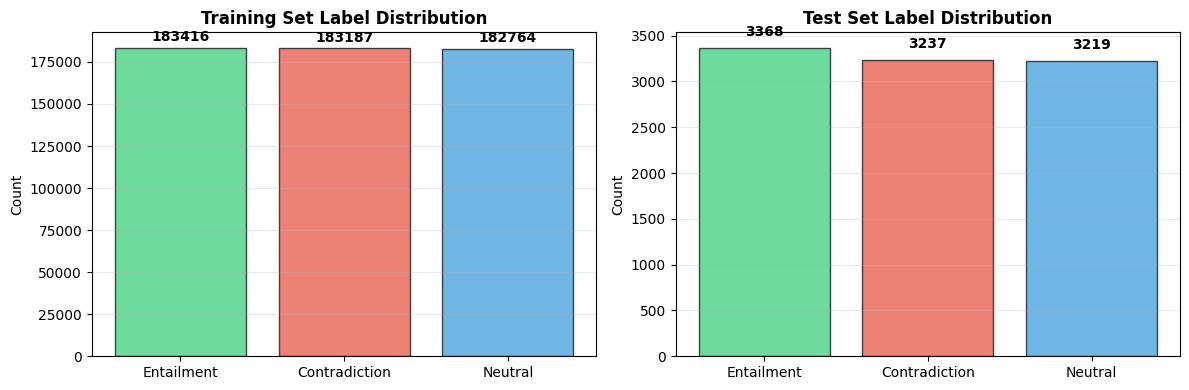

In [10]:
# Label distribution
train_label_counts = [train_data[2].count(i) for i in range(3)]
test_label_counts = [test_data[2].count(i) for i in range(3)]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
labels = ['Entailment', 'Contradiction', 'Neutral']
colors = ['#2ecc71', '#e74c3c', '#3498db']

# Train set distribution
axes[0].bar(labels, train_label_counts, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Training Set Label Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_label_counts):
    axes[0].text(i, v + 2000, str(v), ha='center', va='bottom', fontweight='bold')

# Test set distribution
axes[1].bar(labels, test_label_counts, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('Test Set Label Distribution', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_label_counts):
    axes[1].text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

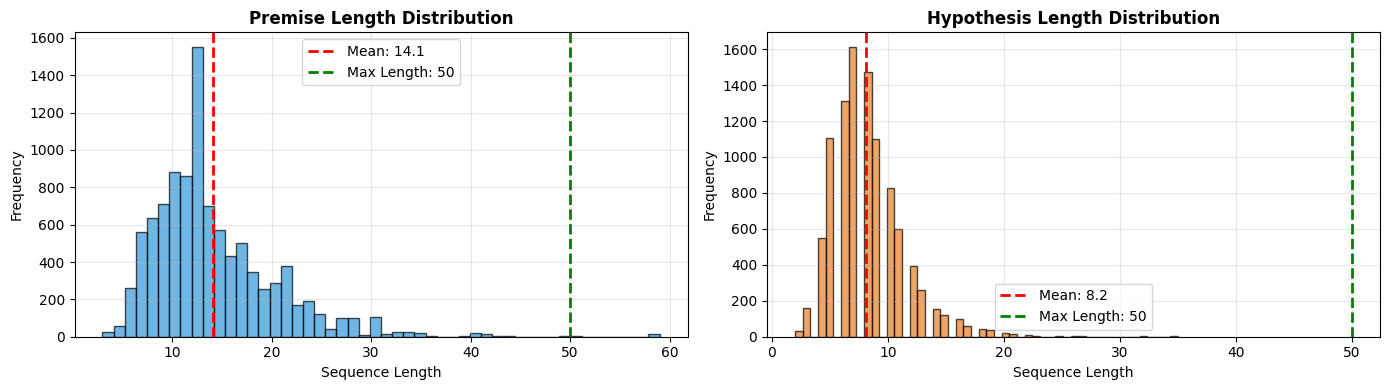

Average premise length: 14.13
Average hypothesis length: 8.16


In [11]:
# Sequence length distribution
premise_lengths = [len(p.split()) for p in train_data[0][:10000]]
hypothesis_lengths = [len(h.split()) for h in train_data[1][:10000]]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Premise lengths
axes[0].hist(premise_lengths, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(premise_lengths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(premise_lengths):.1f}')
axes[0].axvline(50, color='green', linestyle='--', linewidth=2, label='Max Length: 50')
axes[0].set_xlabel('Sequence Length', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].set_title('Premise Length Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Hypothesis lengths
axes[1].hist(hypothesis_lengths, bins=50, color='#e67e22', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(hypothesis_lengths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(hypothesis_lengths):.1f}')
axes[1].axvline(50, color='green', linestyle='--', linewidth=2, label='Max Length: 50')
axes[1].set_xlabel('Sequence Length', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].set_title('Hypothesis Length Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average premise length: {np.mean(premise_lengths):.2f}")
print(f"Average hypothesis length: {np.mean(hypothesis_lengths):.2f}")

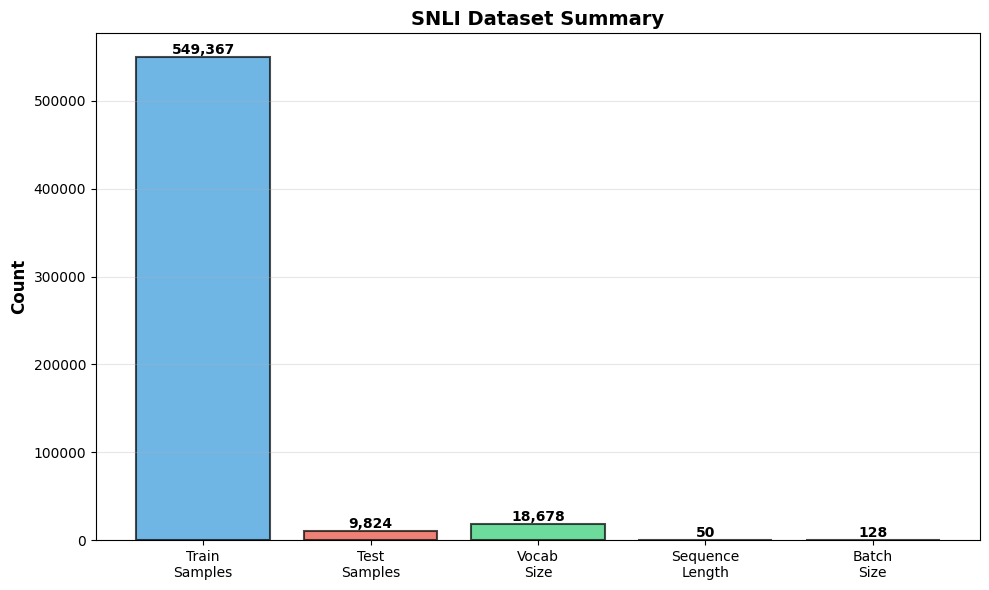

In [12]:
# Dataset summary visualization
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Train\nSamples', 'Test\nSamples', 'Vocab\nSize', 'Sequence\nLength', 'Batch\nSize']
values = [len(train_data[0]), len(test_data[0]), len(vocab), 50, 128]
colors_bar = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

bars = ax.bar(categories, values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('SNLI Dataset Summary', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()